In [3]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [4]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

Processing...
Done!


## Common setup

In [6]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [7]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [8]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.356436	Accuracy: 11.328125
Train: [12800/60000 (21%)]	Loss: 2.346898	Accuracy: 17.708333333333332
Train: [25600/60000 (43%)]	Loss: 1.144468	Accuracy: 36.386138613861384
Train: [38400/60000 (64%)]	Loss: 0.924802	Accuracy: 46.83878311258278
Train: [51200/60000 (85%)]	Loss: 0.819250	Accuracy: 53.29213308457712
Epoch: 1/20. Train set: Average loss: 1.2328	Accuracy: 56.291666666666664
Epoch: 1/20. Validation set: Average loss: 0.7323	Accuracy: 74.99
Train: [0/60000 (0%)]	Loss: 0.799126	Accuracy: 79.296875
Train: [12800/60000 (21%)]	Loss: 0.691741	Accuracy: 77.00674019607843
Train: [25600/60000 (43%)]	Loss: 0.657992	Accuracy: 77.64928836633663
Train: [38400/60000 (64%)]	Loss: 0.615261	Accuracy: 78.54925496688742
Train: [51200/60000 (85%)]	Loss: 0.577393	Accuracy: 79.22691231343283
Epoch: 2/20. Train set: Average loss: 0.6322	Accuracy: 79.49
Epoch: 2/20. Validation set: Average loss: 0.6036	Accuracy: 79.69
Train: [0/60000 (0%)]	Loss: 0.603327	Accuracy: 77.734375


In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Siamese network
We'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

## Steps
1. Create a dataset returning pairs - **SiameseMNIST** class from *datasets.py*, wrapper for MNIST-like classes.
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **siamese** network processing pairs of inputs - **SiameseNet** wrapping *EmbeddingNet*
4. Train the network with **ContrastiveLoss** - *losses.py*

In [4]:
# Set up data loaders
from datasets import SiameseMNIST

# Step 1
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [5]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.231529
Epoch: 1/20. Train set: Average loss: 0.0474
Epoch: 1/20. Validation set: Average loss: 0.0420
Train: [0/60000 (0%)]	Loss: 0.046354
Epoch: 2/20. Train set: Average loss: 0.0370
Epoch: 2/20. Validation set: Average loss: 0.0374
Train: [0/60000 (0%)]	Loss: 0.039161
Epoch: 3/20. Train set: Average loss: 0.0327
Epoch: 3/20. Validation set: Average loss: 0.0323
Train: [0/60000 (0%)]	Loss: 0.029295
Epoch: 4/20. Train set: Average loss: 0.0290
Epoch: 4/20. Validation set: Average loss: 0.0313
Train: [0/60000 (0%)]	Loss: 0.027676
Epoch: 5/20. Train set: Average loss: 0.0264
Epoch: 5/20. Validation set: Average loss: 0.0311
Train: [0/60000 (0%)]	Loss: 0.021239
Epoch: 6/20. Train set: Average loss: 0.0245
Epoch: 6/20. Validation set: Average loss: 0.0304
Train: [0/60000 (0%)]	Loss: 0.017902
Epoch: 7/20. Train set: Average loss: 0.0231
Epoch: 7/20. Validation set: Average loss: 0.0290
Train: [0/60000 (0%)]	Loss: 0.027262
Epoch: 8/20. Train set: Average loss: 0

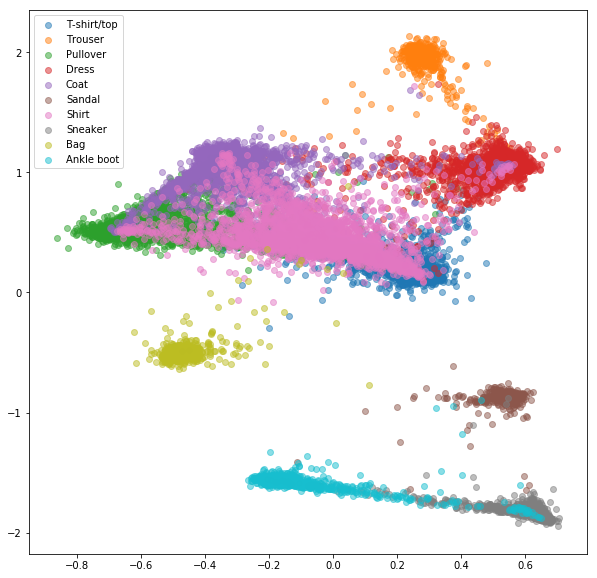

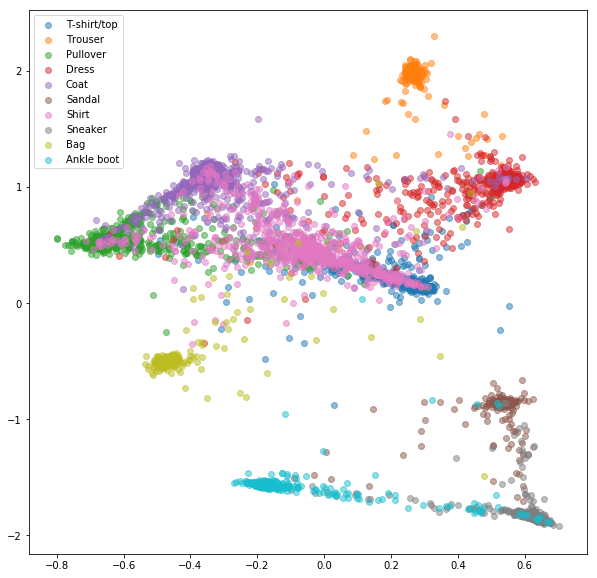

In [6]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [7]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [8]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999584
Epoch: 1/20. Train set: Average loss: 0.2072
Epoch: 1/20. Validation set: Average loss: 0.1662
Train: [0/60000 (0%)]	Loss: 0.101171
Epoch: 2/20. Train set: Average loss: 0.1467
Epoch: 2/20. Validation set: Average loss: 0.1394
Train: [0/60000 (0%)]	Loss: 0.088182
Epoch: 3/20. Train set: Average loss: 0.1264
Epoch: 3/20. Validation set: Average loss: 0.1353
Train: [0/60000 (0%)]	Loss: 0.202603
Epoch: 4/20. Train set: Average loss: 0.1103
Epoch: 4/20. Validation set: Average loss: 0.1257
Train: [0/60000 (0%)]	Loss: 0.114798
Epoch: 5/20. Train set: Average loss: 0.1009
Epoch: 5/20. Validation set: Average loss: 0.1134
Train: [0/60000 (0%)]	Loss: 0.110366
Epoch: 6/20. Train set: Average loss: 0.0945
Epoch: 6/20. Validation set: Average loss: 0.1160
Train: [0/60000 (0%)]	Loss: 0.110644
Epoch: 7/20. Train set: Average loss: 0.0874
Epoch: 7/20. Validation set: Average loss: 0.1117
Train: [0/60000 (0%)]	Loss: 0.048617
Epoch: 8/20. Train set: Average loss: 0

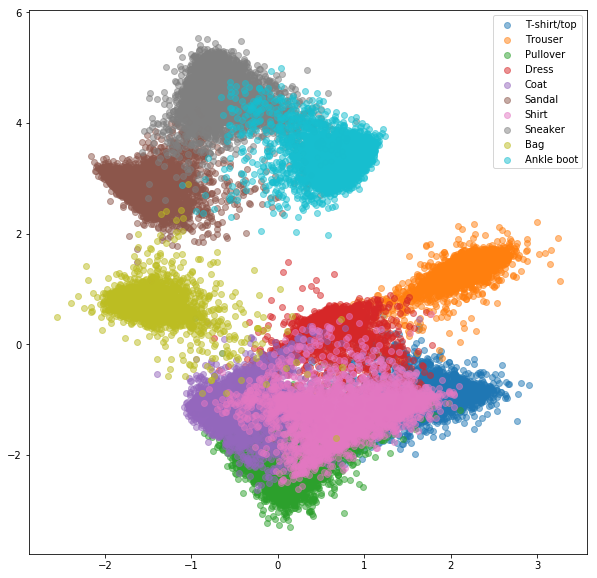

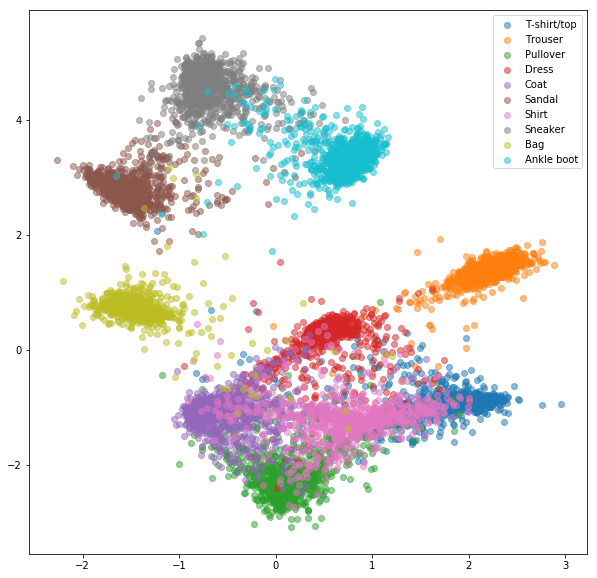

In [9]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datsets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [18]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

In [19]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.493686
Epoch: 1/20. Train set: Average loss: 0.2559
Epoch: 1/20. Validation set: Average loss: 0.1993
Train: [0/60000 (0%)]	Loss: 0.206144
Epoch: 2/20. Train set: Average loss: 0.1802
Epoch: 2/20. Validation set: Average loss: 0.1700
Train: [0/60000 (0%)]	Loss: 0.152808
Epoch: 3/20. Train set: Average loss: 0.1553
Epoch: 3/20. Validation set: Average loss: 0.1606
Train: [0/60000 (0%)]	Loss: 0.186473
Epoch: 4/20. Train set: Average loss: 0.1356
Epoch: 4/20. Validation set: Average loss: 0.1516
Train: [0/60000 (0%)]	Loss: 0.135683
Epoch: 5/20. Train set: Average loss: 0.1213
Epoch: 5/20. Validation set: Average loss: 0.1573
Train: [0/60000 (0%)]	Loss: 0.135574
Epoch: 6/20. Train set: Average loss: 0.1098
Epoch: 6/20. Validation set: Average loss: 0.1460
Train: [0/60000 (0%)]	Loss: 0.088923
Epoch: 7/20. Train set: Average loss: 0.0996
Epoch: 7/20. Validation set: Average loss: 0.1460
Train: [0/60000 (0%)]	Loss: 0.123782
Epoch: 8/20. Train set: Average loss: 0

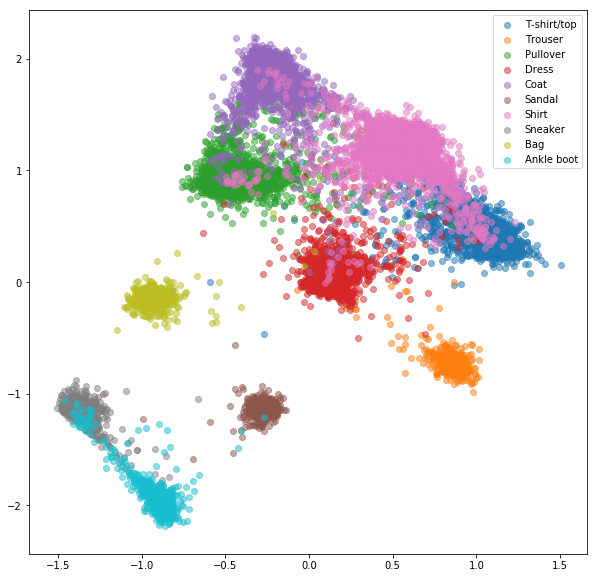

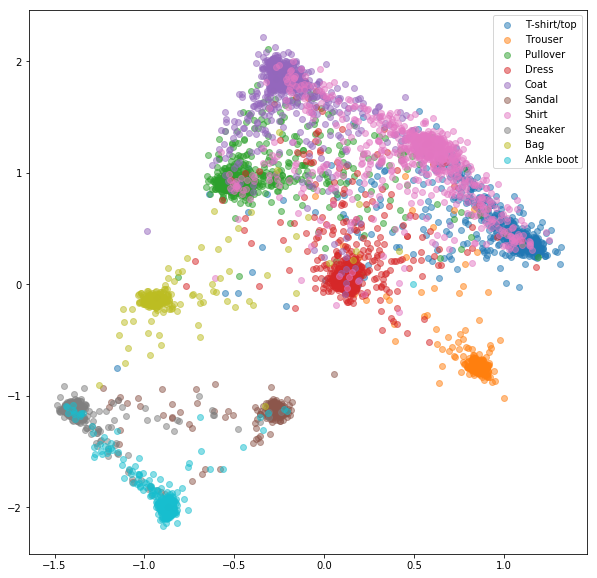

In [20]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datsets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [13]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

In [14]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999857	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.995048	Average nonzero triplets: 2510.2847682119204
Epoch: 1/20. Train set: Average loss: 0.9980	Average nonzero triplets: 2378.9874476987447
Epoch: 1/20. Validation set: Average loss: 1.0347	Average nonzero triplets: 2064.871794871795
Train: [0/60000 (0%)]	Loss: 1.067607	Average nonzero triplets: 2038.0
Train: [37500/60000 (62%)]	Loss: 0.996401	Average nonzero triplets: 2050.364238410596
Epoch: 2/20. Train set: Average loss: 0.9970	Average nonzero triplets: 2022.7280334728034
Epoch: 2/20. Validation set: Average loss: 1.0118	Average nonzero triplets: 1971.051282051282
Train: [0/60000 (0%)]	Loss: 0.930200	Average nonzero triplets: 1930.0
Train: [37500/60000 (62%)]	Loss: 0.992478	Average nonzero triplets: 1861.8079470198675
Epoch: 3/20. Train set: Average loss: 0.9985	Average nonzero triplets: 1868.5062761506276
Epoch: 3/20. Validation set: Average loss: 0.9535	Average nonzero triple

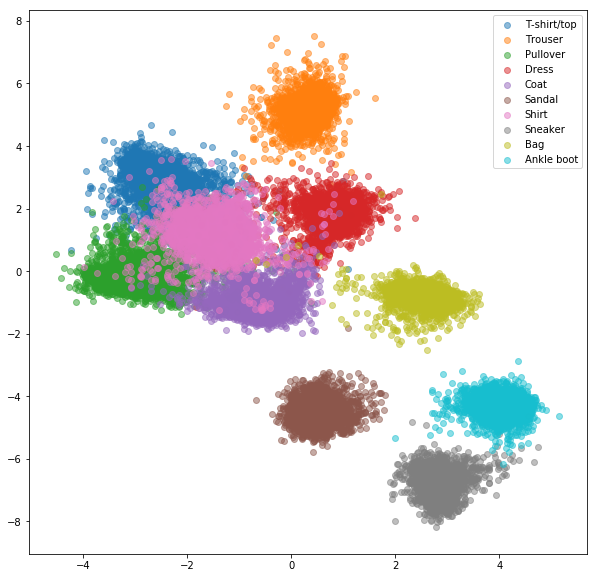

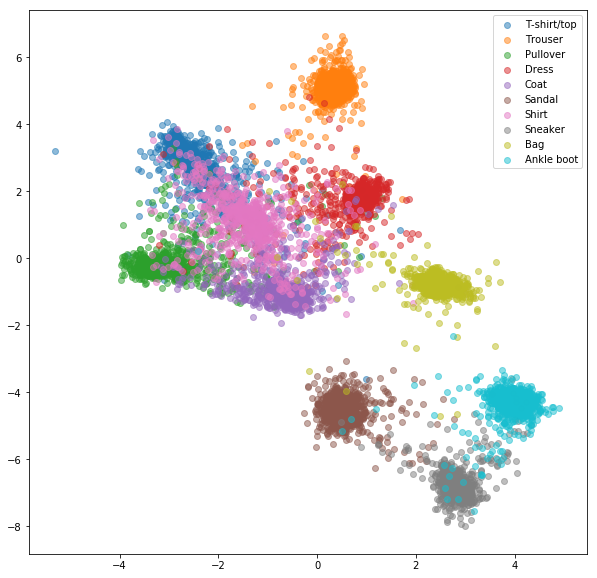

In [15]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

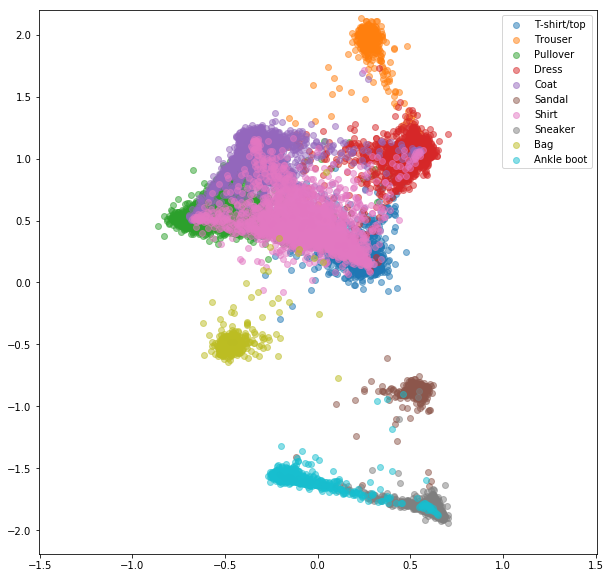

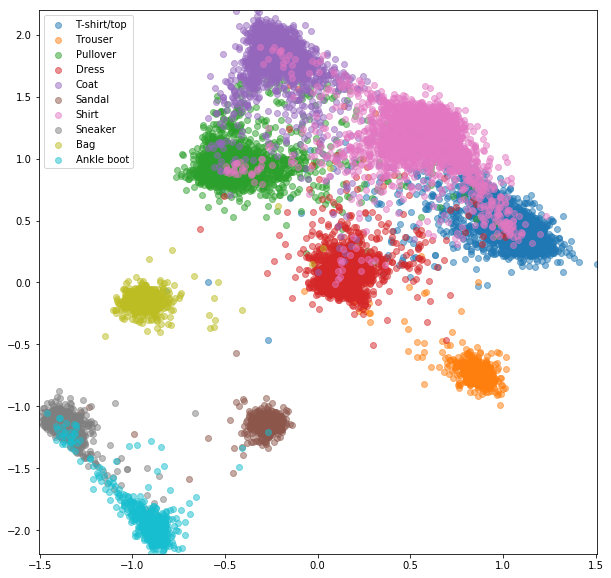

In [24]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_ocl, train_embeddings_cl, train_labels_ocl, train_labels_cl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_ocl, val_embeddings_cl, val_labels_ocl, val_labels_cl

x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))

plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

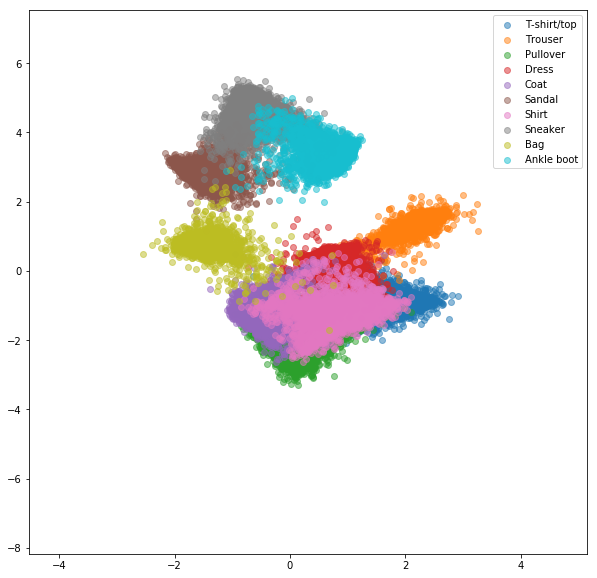

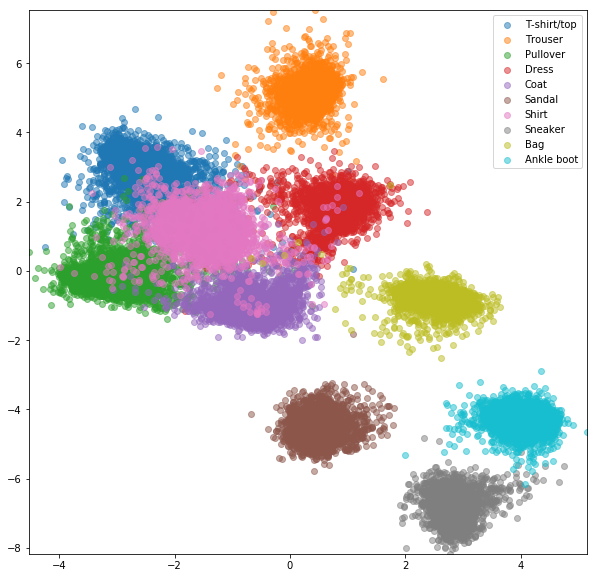

In [17]:
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)